<a href="https://colab.research.google.com/github/venkatesh-manikumar/Datascience-Assignments/blob/main/Predict_The_Flight_Ticket_Price_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
##drive.mount('/content/drive')

In [2]:
import pandas as pd
import holidays
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder , OneHotEncoder , LabelBinarizer
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

In [3]:
train_data = pd.read_excel('/content/drive/MyDrive/DataScience/Flight_price_prediction/Data_Train.xlsx')
test_data_sample  = pd.read_excel('/content/drive/MyDrive/DataScience/Flight_price_prediction/Test_set.xlsx')
test_data_sample['Price'] = train_data.Price.median()

train_data = pd.concat([train_data,test_data_sample])

In [4]:
train_data.shape

(13354, 11)

In [5]:
train_data.dtypes

Airline             object
Date_of_Journey     object
Source              object
Destination         object
Route               object
Dep_Time            object
Arrival_Time        object
Duration            object
Total_Stops         object
Additional_Info     object
Price              float64
dtype: object

In [6]:
#train_data.drop_duplicates(inplace=True)
train_data.shape

(13354, 11)

Missing data stats

In [7]:
train_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [8]:
train_data[train_data['Total_Stops'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480.0


In [9]:
train_data[train_data['Route'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480.0


In [10]:
train_data.dropna(inplace=True)
train_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [11]:
train_data.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897.0
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662.0
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218.0
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302.0


Feature Engineering

In [12]:
train_data['Airline'].unique()

array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia',
       'Vistara Premium economy', 'Jet Airways Business',
       'Multiple carriers Premium economy', 'Trujet'], dtype=object)

In [13]:
train_data['Journey_date'] = pd.to_datetime(train_data['Date_of_Journey'],dayfirst=True)
#train_data['Day'] =train_data['Journey_date'].apply(lambda x:x.day_name())
train_data['Day_of_week'] =train_data['Journey_date'].apply(lambda x:x.isoweekday())

train_data.drop(['Date_of_Journey'],axis=1,inplace=True)

train_data.dtypes

Airline                    object
Source                     object
Destination                object
Route                      object
Dep_Time                   object
Arrival_Time               object
Duration                   object
Total_Stops                object
Additional_Info            object
Price                     float64
Journey_date       datetime64[ns]
Day_of_week                 int64
dtype: object

In [14]:
train_data.head(5)

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_date,Day_of_week
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897.0,2019-03-24,7
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662.0,2019-05-01,3
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0,2019-06-09,7
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218.0,2019-05-12,7
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302.0,2019-03-01,5


In [15]:
India_holidays = holidays.India()
train_data['isHoliday'] =train_data['Journey_date'].apply(lambda x: 1 if x in India_holidays else 0)


In [16]:

for i in range(0,train_data['Route'].str.count("→").max()):
  column_name =   "Route_"+str(i)
  train_data[column_name]= train_data['Route'].str.split('→ ').str[i]
  train_data[column_name].fillna('0',inplace=True)


train_data['Source'] = train_data['Route_0']
train_data.drop(['Route'],axis=1,inplace=True)
train_data.drop(['Journey_date'],axis=1,inplace=True)

train_data.head(5)


,Airline,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Day_of_week,isHoliday,Route_0,Route_1,Route_2,Route_3,Route_4
0,IndiGo,BLR,New Delhi,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897.0,7,0,BLR,DEL,0,0,0
1,Air India,CCU,Banglore,05:50,13:15,7h 25m,2 stops,No info,7662.0,3,1,CCU,IXR,BBI,BLR,0
2,Jet Airways,DEL,Cochin,09:25,04:25 10 Jun,19h,2 stops,No info,13882.0,7,1,DEL,LKO,BOM,COK,0
3,IndiGo,CCU,Banglore,18:05,23:30,5h 25m,1 stop,No info,6218.0,7,0,CCU,NAG,BLR,0,0
4,IndiGo,BLR,New Delhi,16:50,21:35,4h 45m,1 stop,No info,13302.0,5,0,BLR,NAG,DEL,0,0


In [17]:
train_data.Total_Stops.value_counts()

1 stop      7056
non-stop    4340
2 stops     1899
3 stops       56
4 stops        2
Name: Total_Stops, dtype: int64

In [18]:
train_data['Total_Stops'] = train_data.Total_Stops.str.split(" ").str[0]
train_data['Total_Stops'] = train_data['Total_Stops'].replace('non-stop','0')
train_data['Total_Stops'] = train_data['Total_Stops'].astype(int)

train_data.head()


,Airline,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Day_of_week,isHoliday,Route_0,Route_1,Route_2,Route_3,Route_4
0,IndiGo,BLR,New Delhi,22:20,01:10 22 Mar,2h 50m,0,No info,3897.0,7,0,BLR,DEL,0,0,0
1,Air India,CCU,Banglore,05:50,13:15,7h 25m,2,No info,7662.0,3,1,CCU,IXR,BBI,BLR,0
2,Jet Airways,DEL,Cochin,09:25,04:25 10 Jun,19h,2,No info,13882.0,7,1,DEL,LKO,BOM,COK,0
3,IndiGo,CCU,Banglore,18:05,23:30,5h 25m,1,No info,6218.0,7,0,CCU,NAG,BLR,0,0
4,IndiGo,BLR,New Delhi,16:50,21:35,4h 45m,1,No info,13302.0,5,0,BLR,NAG,DEL,0,0


<Axes: xlabel='Additional_Info'>

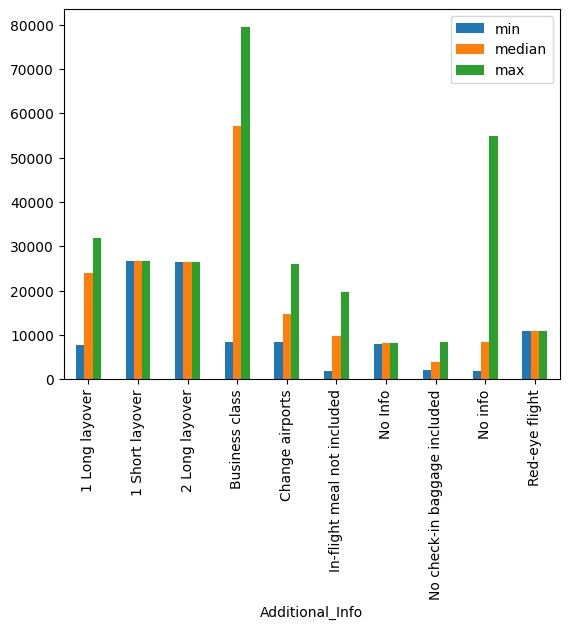

In [19]:
train_data.Additional_Info.unique()
train_data.groupby('Additional_Info')['Price'].aggregate(['min','median','max']).plot(kind='bar')


In [20]:
train_data.Additional_Info.value_counts()

No info                         10492
In-flight meal not included      2426
No check-in baggage included      396
1 Long layover                     20
Change airports                     8
Business class                      5
No Info                             3
1 Short layover                     1
Red-eye flight                      1
2 Long layover                      1
Name: Additional_Info, dtype: int64

In [21]:
np.sort(train_data.Dep_Time.str.split(':').str[0].astype(int).unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [22]:
train_data['Dep_hour'] = train_data.Dep_Time.str.split(':').str[0].astype(int)
train_data['Dep_minutes'] = train_data.Dep_Time.str.split(':').str[1].astype(int)

train_data.drop(['Dep_Time'],axis=1,inplace=True)

In [23]:
train_data.head()

,Airline,Source,Destination,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Day_of_week,isHoliday,Route_0,Route_1,Route_2,Route_3,Route_4,Dep_hour,Dep_minutes
0,IndiGo,BLR,New Delhi,01:10 22 Mar,2h 50m,0,No info,3897.0,7,0,BLR,DEL,0,0,0,22,20
1,Air India,CCU,Banglore,13:15,7h 25m,2,No info,7662.0,3,1,CCU,IXR,BBI,BLR,0,5,50
2,Jet Airways,DEL,Cochin,04:25 10 Jun,19h,2,No info,13882.0,7,1,DEL,LKO,BOM,COK,0,9,25
3,IndiGo,CCU,Banglore,23:30,5h 25m,1,No info,6218.0,7,0,CCU,NAG,BLR,0,0,18,5
4,IndiGo,BLR,New Delhi,21:35,4h 45m,1,No info,13302.0,5,0,BLR,NAG,DEL,0,0,16,50


In [24]:
train_data['Arrival_hour'] = train_data.Arrival_Time.str.split(':').str[0].astype(int)
train_data['Arrival_minutes'] = train_data.Arrival_Time.str.split(':').str[1].str.split(' ').str[0].astype(int)

train_data.drop(['Arrival_Time'],axis=1,inplace=True)

train_data.head()

,Airline,Source,Destination,Duration,Total_Stops,Additional_Info,Price,Day_of_week,isHoliday,Route_0,Route_1,Route_2,Route_3,Route_4,Dep_hour,Dep_minutes,Arrival_hour,Arrival_minutes
0,IndiGo,BLR,New Delhi,2h 50m,0,No info,3897.0,7,0,BLR,DEL,0,0,0,22,20,1,10
1,Air India,CCU,Banglore,7h 25m,2,No info,7662.0,3,1,CCU,IXR,BBI,BLR,0,5,50,13,15
2,Jet Airways,DEL,Cochin,19h,2,No info,13882.0,7,1,DEL,LKO,BOM,COK,0,9,25,4,25
3,IndiGo,CCU,Banglore,5h 25m,1,No info,6218.0,7,0,CCU,NAG,BLR,0,0,18,5,23,30
4,IndiGo,BLR,New Delhi,4h 45m,1,No info,13302.0,5,0,BLR,NAG,DEL,0,0,16,50,21,35


In [25]:
train_data['Duration_hour']  = train_data.Duration.str.split(' ').str[0].str.split('h').str[0].str.split('m').str[0].astype(int)
train_data['Duration_minutes']  = train_data.Duration.str.split(' ').str[1].fillna('0m').str.split('m').str[0].astype(int)
train_data['Total_Duration'] = train_data['Duration_hour'] *60 + train_data['Duration_minutes']


train_data.drop(['Duration'],axis=1,inplace=True)
train_data.drop(['Duration_hour'],axis=1,inplace=True)
train_data.drop(['Duration_minutes'],axis=1,inplace=True)



#train_data['Duration_minutes'].str.contains('m').value_counts()

#train_data[train_data.Duration.str.split(' ').str[0].str.split('h').str[0] == '5m']

In [26]:
train_data.head()


,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Day_of_week,isHoliday,Route_0,Route_1,Route_2,Route_3,Route_4,Dep_hour,Dep_minutes,Arrival_hour,Arrival_minutes,Total_Duration
0,IndiGo,BLR,New Delhi,0,No info,3897.0,7,0,BLR,DEL,0,0,0,22,20,1,10,170
1,Air India,CCU,Banglore,2,No info,7662.0,3,1,CCU,IXR,BBI,BLR,0,5,50,13,15,445
2,Jet Airways,DEL,Cochin,2,No info,13882.0,7,1,DEL,LKO,BOM,COK,0,9,25,4,25,1140
3,IndiGo,CCU,Banglore,1,No info,6218.0,7,0,CCU,NAG,BLR,0,0,18,5,23,30,325
4,IndiGo,BLR,New Delhi,1,No info,13302.0,5,0,BLR,NAG,DEL,0,0,16,50,21,35,285


In [27]:
#one_hot_encoded_data = pd.get_dummies(train_data, columns = ['Airline','Additional_Info'])
#one_hot_encoded_data =train_data

enc = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
encoder = enc.fit_transform(train_data[['Airline','Additional_Info']])
one_hot_encoded = pd.DataFrame(encoder,columns=enc.get_feature_names_out())


one_hot_encoded_data = train_data.join(one_hot_encoded)



In [28]:
def label_encode_columns(df, columns):
    encoders = {}
    for col in columns:
        le = LabelEncoder().fit(df[col])
        df[col] = le.transform(df[col])
        encoders[col] = le
    return df, encoders

encode_columns =['Source','Destination','Route_1','Route_2','Route_3','Route_4','Route_0']
train_df, encoders = label_encode_columns(df=one_hot_encoded_data, columns=encode_columns)


train_df.drop(['Airline','Additional_Info','Source','Destination'],axis=1,inplace=True)
train_data = train_df.copy()

encoders

{'Source': LabelEncoder(),
 'Destination': LabelEncoder(),
 'Route_1': LabelEncoder(),
 'Route_2': LabelEncoder(),
 'Route_3': LabelEncoder(),
 'Route_4': LabelEncoder(),
 'Route_0': LabelEncoder()}

In [29]:
train_data.dtypes

Total_Stops                                       int64
Price                                           float64
Day_of_week                                       int64
isHoliday                                         int64
Route_0                                           int64
Route_1                                           int64
Route_2                                           int64
Route_3                                           int64
Route_4                                           int64
Dep_hour                                          int64
Dep_minutes                                       int64
Arrival_hour                                      int64
Arrival_minutes                                   int64
Total_Duration                                    int64
Airline_Air Asia                                float64
Airline_Air India                               float64
Airline_GoAir                                   float64
Airline_IndiGo                                  

<Axes: >

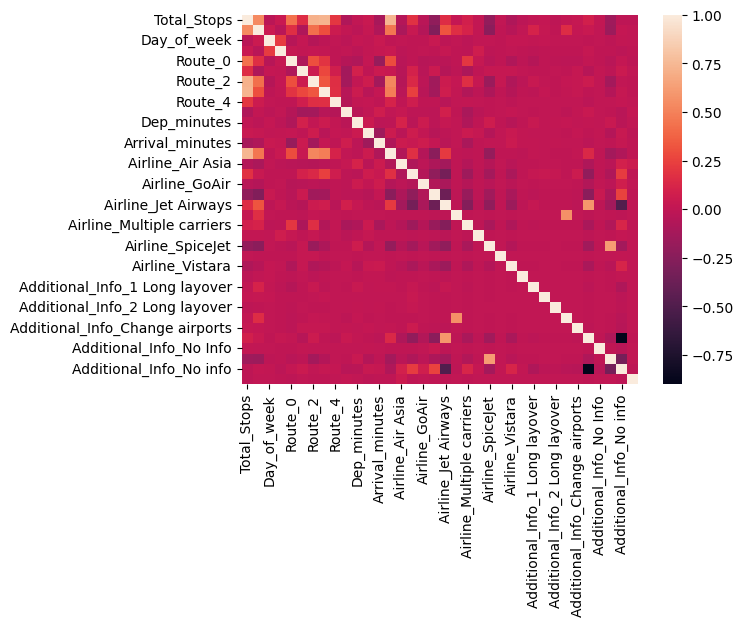

In [30]:
sns.heatmap(train_data.corr())

In [31]:
lin_reg = LinearRegression()
train_labels = train_data['Price'].copy()
train= train_data.drop(columns = ['Price'],axis=1)
lin_reg.fit(train,train_labels)

LinearRegression()

In [32]:
test_data = pd.read_excel('/content/drive/MyDrive/DataScience/Flight_price_prediction/Test_set.xlsx')

In [33]:
test_data.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [34]:
#test_data.drop_duplicates(inplace=True)
test_data.shape

(2671, 10)

In [35]:
test_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

In [36]:
test_data['Journey_date'] = pd.to_datetime(test_data['Date_of_Journey'],dayfirst=True)
#train_data['Day'] =train_data['Journey_date'].apply(lambda x:x.day_name())
test_data['Day_of_week'] =test_data['Journey_date'].apply(lambda x:x.isoweekday())

test_data.drop(['Date_of_Journey'],axis=1,inplace=True)

test_data.dtypes

Airline                    object
Source                     object
Destination                object
Route                      object
Dep_Time                   object
Arrival_Time               object
Duration                   object
Total_Stops                object
Additional_Info            object
Journey_date       datetime64[ns]
Day_of_week                 int64
dtype: object

In [37]:
India_holidays = holidays.India()
test_data['isHoliday'] =test_data['Journey_date'].apply(lambda x: 1 if x in India_holidays else 0)

In [38]:
for i in range(0,test_data['Route'].str.count("→").max()):
  column_name = "Route_"+str(i)
  test_data[column_name]= test_data['Route'].str.split('→ ').str[i]
  test_data[column_name].fillna('0',inplace=True)

test_data['Source'] = test_data['Route_0']
test_data.drop(['Route'],axis=1,inplace=True)
test_data.drop(['Journey_date'],axis=1,inplace=True)

In [39]:
test_data['Total_Stops'] = test_data.Total_Stops.str.split(' ').str[0]
test_data['Total_Stops'] = test_data['Total_Stops'].replace('non-stop','0')
test_data['Total_Stops'] = test_data['Total_Stops'].astype(int)

test_data[test_data['Total_Stops'].isna()]

,Airline,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Day_of_week,isHoliday,Route_0,Route_1,Route_2,Route_3,Route_4


In [40]:
test_data['Dep_hour'] = test_data.Dep_Time.str.split(':').str[0].astype(int)
test_data['Dep_minutes'] = test_data.Dep_Time.str.split(':').str[1].astype(int)




test_data.drop(['Dep_Time'],axis=1,inplace=True)

In [41]:
test_data['Arrival_hour'] = test_data.Arrival_Time.str.split(':').str[0].astype(int)
test_data['Arrival_minutes'] = test_data.Arrival_Time.str.split(':').str[1].str.split(' ').str[0].astype(int)

test_data.drop(['Arrival_Time'],axis=1,inplace=True)

In [42]:
test_data['Duration_hour']  = test_data.Duration.str.split(' ').str[0].str.split('h').str[0].str.split('m').str[0].astype(int)
test_data['Duration_minutes']  = test_data.Duration.str.split(' ').str[1].fillna('0m').str.split('m').str[0].astype(int)
test_data['Total_Duration'] = test_data['Duration_hour'] *60 + test_data['Duration_minutes']


test_data.drop(['Duration'],axis=1,inplace=True)
test_data.drop(['Duration_hour'],axis=1,inplace=True)
test_data.drop(['Duration_minutes'],axis=1,inplace=True)

test_data.head(5)

,Airline,Source,Destination,Total_Stops,Additional_Info,Day_of_week,isHoliday,Route_0,Route_1,Route_2,Route_3,Route_4,Dep_hour,Dep_minutes,Arrival_hour,Arrival_minutes,Total_Duration
0,Jet Airways,DEL,Cochin,1,No info,4,0,DEL,BOM,COK,0,0,17,30,4,25,655
1,IndiGo,CCU,Banglore,1,No info,7,0,CCU,MAA,BLR,0,0,6,20,10,20,240
2,Jet Airways,DEL,Cochin,1,In-flight meal not included,2,0,DEL,BOM,COK,0,0,19,15,19,0,1425
3,Multiple carriers,DEL,Cochin,1,No info,2,0,DEL,BOM,COK,0,0,8,0,21,0,780
4,Air Asia,BLR,Delhi,0,No info,1,0,BLR,DEL,0,0,0,23,55,2,45,170


In [43]:
#one_hot_encoded_data = pd.get_dummies(test_data, columns = ['Airline','Additional_Info'])
#one_hot_encoded_data=test_data


#enc = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
one_hot_encoded = pd.DataFrame(enc.transform(test_data[['Airline','Additional_Info']]),columns=enc.get_feature_names_out())


one_hot_encoded_data = test_data.join(one_hot_encoded)
one_hot_encoded_data

,Airline,Source,Destination,Total_Stops,Additional_Info,Day_of_week,isHoliday,Route_0,Route_1,Route_2,...,Additional_Info_1 Long layover,Additional_Info_1 Short layover,Additional_Info_2 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No Info,Additional_Info_No check-in baggage included,Additional_Info_No info,Additional_Info_Red-eye flight
0,Jet Airways,DEL,Cochin,1,No info,4,0,DEL,BOM,COK,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,IndiGo,CCU,Banglore,1,No info,7,0,CCU,MAA,BLR,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Jet Airways,DEL,Cochin,1,In-flight meal not included,2,0,DEL,BOM,COK,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,Multiple carriers,DEL,Cochin,1,No info,2,0,DEL,BOM,COK,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,Air Asia,BLR,Delhi,0,No info,1,0,BLR,DEL,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,Air India,CCU,Banglore,1,No info,4,0,CCU,DEL,BLR,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2667,IndiGo,CCU,Banglore,0,No info,3,0,CCU,BLR,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2668,Jet Airways,DEL,Cochin,1,No info,3,0,DEL,BOM,COK,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2669,Air India,DEL,Cochin,1,No info,3,0,DEL,BOM,COK,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [44]:
def label_encode_columns_w_fit_encoders(df, columns, encoders):
    for col in columns:
        le = encoders.get(col)
        df[col] = le.fit_transform(df[col])
    return df

score_df = label_encode_columns_w_fit_encoders(df=one_hot_encoded_data, columns=encode_columns, encoders=encoders)

score_df.drop(['Airline','Additional_Info','Source','Destination'],axis=1,inplace=True)

test_data = score_df.copy()


In [45]:
test_data.dtypes

Total_Stops                                       int64
Day_of_week                                       int64
isHoliday                                         int64
Route_0                                           int64
Route_1                                           int64
Route_2                                           int64
Route_3                                           int64
Route_4                                           int64
Dep_hour                                          int64
Dep_minutes                                       int64
Arrival_hour                                      int64
Arrival_minutes                                   int64
Total_Duration                                    int64
Airline_Air Asia                                float64
Airline_Air India                               float64
Airline_GoAir                                   float64
Airline_IndiGo                                  float64
Airline_Jet Airways                             

In [46]:
test_data.head(10)

,Total_Stops,Day_of_week,isHoliday,Route_0,Route_1,Route_2,Route_3,Route_4,Dep_hour,Dep_minutes,...,Additional_Info_1 Long layover,Additional_Info_1 Short layover,Additional_Info_2 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No Info,Additional_Info_No check-in baggage included,Additional_Info_No info,Additional_Info_Red-eye flight
0,1,4,0,3,7,6,0,0,17,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,7,0,2,29,4,0,0,6,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,2,0,3,7,6,0,0,19,15,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,2,0,3,7,6,0,0,8,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,1,0,0,13,0,0,0,23,55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,1,3,0,3,7,6,0,0,18,15,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,1,2,0,0,35,8,0,0,7,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,1,3,1,2,19,4,0,0,15,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,0,5,0,2,5,0,0,0,10,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,1,6,0,2,7,4,0,0,16,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [47]:
DF = pd.DataFrame(lin_reg.predict(test_data))
DF.to_csv("/content/drive/MyDrive/DataScience/Flight_price_prediction/result_linear_regression.csv",index=False,header=['Price'])

In [48]:
poly_features = PolynomialFeatures(degree =2)
x_poly = poly_features.fit_transform(train_data.drop(columns = ['Price'],axis=1))


In [49]:
lin_reg_poly = LinearRegression()
train_labels = train_data['Price'].copy()
train= train_data.drop(columns = ['Price'],axis=1)
lin_reg_poly.fit(x_poly,train_labels)

LinearRegression()

In [50]:
x_poly_test = poly_features.transform(test_data)

In [51]:
DF_poly = pd.DataFrame(lin_reg_poly.predict(x_poly_test))
DF_poly[0] = abs(DF_poly[0])
DF_poly.to_csv("/content/drive/MyDrive/DataScience/Flight_price_prediction/result_PolynomialFeatures_2.csv",index=False,header=['Price'])


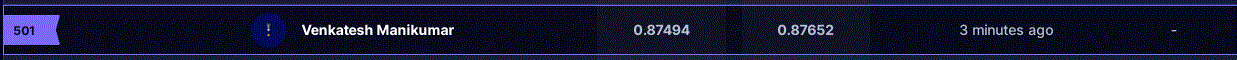